In [1]:
from torchvision.transforms import Resize
from utils import *
from models.closedform.utils import load_generator
from torchvision.utils import save_image
import numpy as np
import random
from collections import OrderedDict
import torch.nn.functional as F
from torchvision.models import resnet18
import torch.nn as nn
import matplotlib.pylab as plt
import torchvision
import cv2
from IPython import display
from evaluation import Evaluator
%matplotlib inline

In [2]:
def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)

# SRE Rescoring Matrix Analysis

In [3]:

all_attr_list = ['pose', 'young', 'male', 'smiling', 'eyeglasses', 'Bald',
                              'Sideburns', 'Wearing_Lipstick', 'Pale_Skin',
                              'No_Beard', 'Wearing_Hat', 'Goatee',
                              'Mustache', 'Double_Chin', 'Gray_Hair',
                              'Wearing_Necktie', 'Blurry', 'Bangs']
attr_index = list(range(len(all_attr_list)))
attr_list_dict = OrderedDict(zip(all_attr_list, attr_index))

attributes = ['pose', 'male', 'young', 'smiling', 'eyeglasses']
root_dir = '/home/adarsh/PycharmProjects/disentagled_latent_dirs'
result_path = os.path.join(root_dir,  'results/celeba_hq/closed_form_ours/quantitative_analysis')
rescoring_matrix = torch.load(os.path.join(result_path, 'rescoring matrix.pkl'))
attr_manipulation_acc = torch.load(os.path.join(result_path, 'attribute manipulation accuracy.pkl'))
direction_idx = [2, 1, 11, 5, 14]
attr_vs_direction = OrderedDict(zip(attributes, direction_idx))
rescoring_labels = ['Pose', 'Gender', 'Age', 'Smile', 'Glasses']
Evaluator.get_partial_metrics(result_path, attributes, direction_idx, attr_list_dict, attr_vs_direction, rescoring_matrix,
                              rescoring_labels, attr_manipulation_acc)

(array([[0.69, 0.13, 0.2 , 0.1 , 0.04],
        [0.15, 0.63, 0.06, 0.07, 0.04],
        [0.15, 0.02, 0.46, 0.16, 0.  ],
        [0.05, 0.01, 0.05, 0.43, 0.04],
        [0.06, 0.06, 0.07, 0.01, 0.2 ]], dtype=float32),
 OrderedDict([('pose', 0.23828125),
              ('male', 0.8574219),
              ('young', 0.001953125),
              ('smiling', 0.001953125),
              ('eyeglasses', 0.39257812)]))

# CF Rescoring Matrix Analysis

In [4]:

all_attr_list = ['pose', 'young', 'male', 'smiling', 'eyeglasses', 'Bald',
                              'Sideburns', 'Wearing_Lipstick', 'Pale_Skin',
                              'No_Beard', 'Wearing_Hat', 'Goatee',
                              'Mustache', 'Double_Chin', 'Gray_Hair',
                              'Wearing_Necktie', 'Blurry', 'Bangs']
attr_index = list(range(len(all_attr_list)))
attr_list_dict = OrderedDict(zip(all_attr_list, attr_index))

attributes = ['pose', 'male', 'young', 'smiling', 'eyeglasses']
root_dir = '/home/adarsh/PycharmProjects/disentagled_latent_dirs'
result_path = os.path.join(root_dir,  'results/celeba_hq/closed_form/quantitative_analysis')
rescoring_matrix = torch.load(os.path.join(result_path, 'rescoring matrix.pkl'))
attr_manipulation_acc = torch.load(os.path.join(result_path, 'attribute manipulation accuracy.pkl'))
direction_idx = [2, 1, 11, 4, 1]
attr_vs_direction = OrderedDict(zip(attributes, direction_idx))
rescoring_labels = ['Pose', 'Gender', 'Age', 'Smile', 'Glasses']
Evaluator.get_partial_metrics(result_path, attributes, direction_idx, attr_list_dict, attr_vs_direction, rescoring_matrix,
                              rescoring_labels, attr_manipulation_acc)

(array([[0.7 , 0.33, 0.22, 0.06, 0.04],
        [0.09, 0.63, 0.76, 0.2 , 0.04],
        [0.09, 0.22, 0.58, 0.27, 0.01],
        [0.17, 0.23, 0.4 , 0.43, 0.04],
        [0.09, 0.63, 0.76, 0.2 , 0.04]], dtype=float32),
 OrderedDict([('pose', 0.0234375),
              ('male', 0.01171875),
              ('young', 0.00390625),
              ('smiling', 0.001953125),
              ('eyeglasses', 0.01171875)]))

# Latent Traversals

## Configurations

In [8]:
random_seed = 1234
set_seed(random_seed)
load_codes = True
algo = 'ortho'
root_dir= '/home/adarsh/PycharmProjects/disentagled_latent_dirs'
result_path = os.path.join(root_dir,  'results/celeba_hq/closed_form_ours/qualitative_analysis')

## Model Selection

In [9]:
deformator_path = os.path.join(root_dir, 'pretrained_models/deformators/ClosedForm/pggan_celebahq1024/pggan_celebahq1024.pkl')
_, cf_deformator, _ = torch.load(deformator_path, map_location='cpu')
cf_deformator = torch.FloatTensor(cf_deformator).cuda()

deformator_path = os.path.join(root_dir, 'results/celeba_hq/closed_form_ours/models/18000_model.pkl')
if algo == 'ortho':
    dse_deformator = torch.load(deformator_path)['deformator']['ortho_mat']
    dse_deformator = dse_deformator.T
elif algo == 'linear':
    deformator = torch.load(os.path.join(deformator_path))['deformator']
    dse_deformator = deformator.T
        
generator = load_generator(None, model_name='pggan_celebahq1024')

# if load_codes:
#     codes = np.load(os.path.join(root_dir, 'pretrained_models/latent_codes/pggan_celebahq1024_latents.npy'))
#     codes = torch.from_numpy(codes).type(torch.FloatTensor).cuda()
#     codes = torch.load(os.path.join(root_dir, 'results/celeba_hq/closed_form_ours/quantitative_analysis/z_analysis.pkl'))
# else:
#     num_samples = 1000
#     codes = torch.randn(num_samples, generator.z_space_dim).cuda()
#     codes = generator.layer0.pixel_norm(codes)
#     codes = codes.detach()

Building generator for model `pggan_celebahq1024` ...
Finish building generator.
Loading checkpoint from `../pretrained_models/generators/ClosedForm/pggan_celebahq1024.pth` ...
Finish loading checkpoint.


In [ ]:
#Instances for Pose and Gender

# codes = []

# num_samples=1000
# z = torch.randn(num_samples, generator.z_space_dim).cuda()
# z = generator.layer0.pixel_norm(z)
# z = z.detach()
# codes.append(z[996])
# codes.append(z[953])

# z = torch.load(os.path.join(root_dir, 'results/celeba_hq/closed_form_ours/quantitative_analysis/z_analysis.pkl'))
# codes.append(z[45])
# codes.append(z[119])
# codes.append(z[207])
# codes.append(z[250])
# codes.append(z[308])

# z = np.load(os.path.join(root_dir, 'pretrained_models/latent_codes/pggan_celebahq1024_latents.npy'))
# z = torch.from_numpy(z).type(torch.FloatTensor).cuda()
# codes.append(z[4])


# codes = torch.stack(codes)

# Instances for Smile

# codes = []

# num_samples=1000
# z = torch.randn(num_samples, generator.z_space_dim).cuda()
# z = generator.layer0.pixel_norm(z)
# z = z.detach()
# indices = [42, 43, 45, 56, 64, 83, 110, 115, 163]
# codes = z[indices]

#Instances for Age

# codes = []

# num_samples=1000
# z = torch.randn(num_samples, generator.z_space_dim).cuda()
# z = generator.layer0.pixel_norm(z)
# z = z.detach()
# indices = [0,6,50,224]
# codes = z[indices]



# Instances for glasses

# codes = []

# num_samples=1000
# z = torch.randn(num_samples, generator.z_space_dim).cuda()
# z = generator.layer0.pixel_norm(z)
# z = z.detach()
# indices = [97, 107, 111, 161, 243, 275, 308, 310, 365]
# codes = z[indices]


In [ ]:
def postprocess_images(images):
        """Post-processes images from `torch.Tensor` to `numpy.ndarray`."""
        images = images.detach().cpu().numpy()
        images = (images + 1) * 255 / 2
        images = np.clip(images + 0.5, 0, 255).astype(np.uint8)
        images = images.transpose(0, 2, 3, 1)
        return images


def save_images(codes, shifts_r, shifts_count, cf_dir, dse_dir, generator, cf_deformator, dse_deformator, min_index):
        plt.figure(figsize=(30,30))
        temp_path =  os.path.join(result_path, 'temp_glasses')
        os.makedirs(temp_path, exist_ok=True)
        torch.save(codes, os.path.join(temp_path, 'codes.pkl'))
        for idx, z in enumerate(codes):
#             print('Figure : ' + str(idx))
            z_shift_cf = []
            z_shift_dse = []
            for i, shift in enumerate(np.linspace(-shifts_r,shifts_r,shifts_count)):
                z_shift_cf.append(z + cf_deformator[cf_dir: cf_dir + 1] * shift)
                z_shift_dse.append(z + dse_deformator[dse_dir: dse_dir + 1] * shift)
            z_shift_cf = torch.stack(z_shift_cf).squeeze(dim=1)
            z_shift_dse = torch.stack(z_shift_dse).squeeze(dim=1)
            with torch.no_grad():
                cf_images= generator(z_shift_cf)
            torch.save(cf_images, os.path.join(temp_path, 'cf.pkl'))
            del cf_images
            with torch.no_grad():
                dse_images= generator(z_shift_dse)
            torch.save(dse_images, os.path.join(temp_path, 'dse.pkl'))
            del dse_images
            cf_images = torch.load(os.path.join(temp_path, 'cf.pkl'))
            dse_images = torch.load(os.path.join(temp_path, 'dse.pkl'))
            all_images = torch.cat((cf_images, dse_images), dim=0)
            grid = torchvision.utils.make_grid(all_images.clamp(min=-1, max=1),nrow=3, scale_each=True, normalize=True)
#             display.display(plt.gcf())
            plt.grid(b=None)
#             plt.axis('off')
            plt.imsave(os.path.join(temp_path, str(min_index) + '.png'), grid.permute(1, 2, 0).cpu().numpy())
            min_index = min_index + 1
            del all_images
            del cf_images
            del dse_images
            del grid
    
z_min_index =0
z_max_index = 1000
cf_dir = 1
dse_dir = 14
shift_r = 5
shift_count = 3
# codes = codes[z_min_index : z_max_index]
# result_path = '/media/adarsh/DATA/CelebA-Analysis'
# codes  = os.path.join(result_path, 'temp_smiling')
# codes = torch.load(os.path.join(codes, 'codes.pkl'))
all_images = save_images(codes, shift_r, shift_count, cf_dir, dse_dir, generator, cf_deformator, dse_deformator, z_min_index)                    

# Plot results

In [5]:
def get_manipulated_images(z, shift_r, shift_count, cf_dir, dse_dir, generator, cf_deformator, dse_deformator):
    temp_path =  os.path.join(result_path, 'temp')
    os.makedirs(temp_path, exist_ok=True)
    z_shift_cf = []
    z_shift_dse = []
    for i, shift in enumerate(np.linspace(-shifts_r,shifts_r,shifts_count)):
        z_shift_cf.append(z + cf_deformator[cf_dir: cf_dir + 1] * shift)
        z_shift_dse.append(z + dse_deformator[dse_dir: dse_dir + 1] * shift)
    z_shift_cf = torch.stack(z_shift_cf).squeeze(dim=1)
    z_shift_dse = torch.stack(z_shift_dse).squeeze(dim=1)
    with torch.no_grad():
        cf_images= generator(z_shift_cf)
    with torch.no_grad():
        dse_images= generator(z_shift_dse)
    return cf_images, dse_images

        

In [6]:
root_dir= '/home/adarsh/PycharmProjects/disentagled_latent_dirs'
result_path = os.path.join(root_dir,  'results/celeba_hq/closed_form_ours/qualitative_analysis')
attr_list = ['Gender', 'Smiling', 'Glasses']
z = []
for each_attr in attr_list:
    z.append(torch.load(os.path.join(result_path, each_attr, 'codes.pkl')))

In [10]:

shifts_r = 6
shifts_count = 3
cf_dir = 1
dse_dir = 1
desired_idx  = 1

cf_gender, dse_gender = get_manipulated_images(z[0][desired_idx], shifts_r, shifts_count, cf_dir, dse_dir, generator, cf_deformator, dse_deformator)


shifts_r = 3
shifts_count = 3
cf_dir = 4
dse_dir = 5
desired_idx  = 7

cf_smiling, dse_smiling = get_manipulated_images(z[1][desired_idx], shifts_r, shifts_count, cf_dir, dse_dir, generator, cf_deformator, dse_deformator)


shifts_r = 5
shifts_count = 3
cf_dir = 1
dse_dir = 14
desired_idx  = 3

cf_glass, dse_glass = get_manipulated_images(z[2][desired_idx], shifts_r, shifts_count, cf_dir, dse_dir, generator, cf_deformator, dse_deformator)



In [11]:
cf = torch.stack((cf_gender, cf_smiling, cf_glass),dim=0)
dse = torch.stack((dse_gender, dse_smiling, dse_glass),dim=0)
all_images = [cf, dse]

In [12]:
algo = ['SeFa', 'SeFa + SRE']

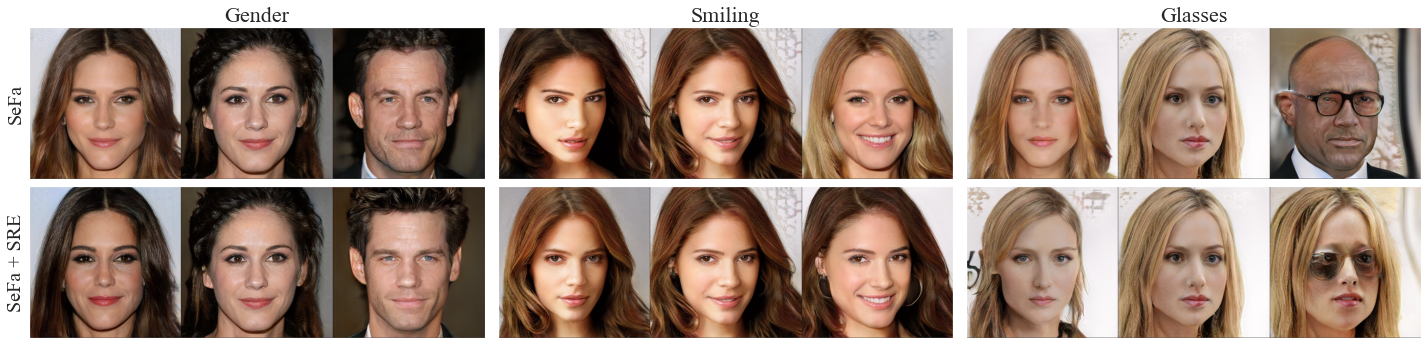

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

SMALL_SIZE = 8
plt.rc('axes', titlesize=22, labelsize=20)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["figure.facecolor"] = 'w'
plt.rcParams["font.family"] = "Times New Roman"

fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.01)
ax = np.zeros(6, dtype=object)
count = 0
for i in range(2):
    for j in range(3):
        ax[count] = fig.add_subplot(gs[i, j])
        grid = torchvision.utils.make_grid(all_images[i][j].clamp(min=-1, max=1),nrow=3, scale_each=True, normalize=True)
        ax[count].imshow(grid.permute(1, 2, 0).cpu().numpy())
        ax[count].grid(False)
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count = count + 1
        ax[j].title.set_text(attr_list[j])
ax[0].set_ylabel(algo[0], rotation=90)
ax[3].set_ylabel(algo[1], rotation=90)


gs.tight_layout(fig)
plt.savefig('test.pdf', bbox_inches = 'tight')
